In [ ]:
!pip install tensorflow

In [2]:
import cv2
import os
import random
import tensorflow as tf
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [5]:
data_dirs = ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Pepper__bell___healthy']

In [9]:
source_path = 'sources'

DATA_CLASSES = ['Bell Pepper Bacterial Spot', 'Potato Healthy', 'Bell Pepper Healthy']

for i, dir in enumerate(data_dirs):
    class_dir = os.path.join(source_path, dir)
    print(f'There are {len(os.listdir(class_dir))} images of {DATA_CLASSES[i]}')

There are 997 images of Bell Pepper Bacterial Spot
There are 152 images of Potato Healthy
There are 1478 images of Bell Pepper Healthy


# Бинарный классификатор

## Создадим папки для тренировочных, валидационных, и тестированных данных

In [3]:
root_binary = 'binary_data'

os.makedirs(os.path.join(root_binary, 'train'))
os.makedirs(os.path.join(root_binary, 'validation'))
os.makedirs(os.path.join(root_binary, 'testing'))

os.makedirs(os.path.join(root_binary, 'train/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'train/potato_healthy'))

os.makedirs(os.path.join(root_binary, 'validation/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'validation/potato_healthy'))

os.makedirs(os.path.join(root_binary, 'testing/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'testing/potato_healthy'))

## Разделим данные на тренировки, валидации, и тестирования

In [7]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, TRAINING_SPLIT, VALIDATION_SPLIT, TESTING_SPLIT):
    filtered_files = []

    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)
        
        if os.path.getsize(file_path):
            filtered_files.append(file_name)
        else:
            print('{} is zero length, so ignoring.'.format(file_name))
  
    # Split the files
    random_files = random.sample(filtered_files, len(filtered_files))
    split_train = int(TRAINING_SPLIT * len(filtered_files))
    split_val = split_train + int(VALIDATION_SPLIT * len(filtered_files))
    split_test = split_val + int(TESTING_SPLIT * len(filtered_files))

    training_files = random_files[:split_train]
    val_files = random_files[split_train:split_val]
    test_files = random_files[split_val:]

    # Copy the files
    for file_name in training_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))

    for file_name in val_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))

    for file_name in test_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name))

In [10]:
BELL_PEPPER_BAC_DIR = "sources/" + data_dirs[0]
POTATO_HEALTHY_DIR = "sources/" + data_dirs[1]

TRAINING_DIR = "binary_data/train/"
VAL_DIR = "binary_data/validation/"
TEST_DIR = "binary_data/testing/"

TRAINING_BELL_PEPPER_BAC_DIR = os.path.join(TRAINING_DIR, "bell_pepper_bac/")
VAL_BELL_PEPPER_BAC_DIR = os.path.join(VAL_DIR, "bell_pepper_bac/")
TEST_BELL_PEPPER_BAC_DIR = os.path.join(TEST_DIR, "bell_pepper_bac/")

TRAINING_POTATO_HEALTHY_DIR = os.path.join(TRAINING_DIR, "potato_healthy/")
VAL_POTATO_HEALTHY_DIR = os.path.join(VAL_DIR, "potato_healthy/")
TEST_POTATO_HEALTHY_DIR = os.path.join(TEST_DIR, "potato_healthy/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TRAINING_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(VAL_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(VAL_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)        
  
if len(os.listdir(TEST_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TEST_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_POTATO_HEALTHY_DIR):
        os.remove(file.path)

        
# Define proportion of images used for training
split_train_size = .7
split_val_size = .2
split_test_size = .1

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(BELL_PEPPER_BAC_DIR, TRAINING_BELL_PEPPER_BAC_DIR, VAL_BELL_PEPPER_BAC_DIR, TEST_BELL_PEPPER_BAC_DIR, 
           split_train_size, split_val_size, split_test_size)
split_data(POTATO_HEALTHY_DIR, TRAINING_POTATO_HEALTHY_DIR, VAL_POTATO_HEALTHY_DIR, TEST_POTATO_HEALTHY_DIR, 
           split_train_size, split_val_size, split_test_size)


# Check that the number of images matches the expected output
print(f"There are {len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for training")
print(f"There are {len(os.listdir(TRAINING_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for training")

print(f"\nThere are {len(os.listdir(VAL_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for validation")
print(f"There are {len(os.listdir(VAL_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for validation")

print(f"\nThere are {len(os.listdir(TEST_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for testing")
print(f"There are {len(os.listdir(TEST_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for testing")

There are 697 images of Bell Pepper Bacterial Spot for training
There are 106 images of Potato Healthy for training

There are 199 images of Bell Pepper Bacterial Spot for validation
There are 55 images of Potato Healthy for validation

There are 101 images of Bell Pepper Bacterial Spot for testing
There are 16 images of Potato Healthy for testing


## Генерации данных для классификации

In [8]:
def train_val_testing_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Instantiate the ImageDataGenerator class 
    train_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                     rotation_range = 40,
                                     width_shift_range = .2,
                                     height_shift_range = .2,
                                     shear_range = .2,
                                     zoom_range = .2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 64,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

    # Instantiate the ImageDataGenerator class 
    validation_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                          rotation_range = 40,
                                          width_shift_range = .2,
                                          height_shift_range = .2,
                                          shear_range = .2,
                                          zoom_range = .2,
                                          horizontal_flip = True,
                                          fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 64,
                                                                class_mode = 'categorical',
                                                                target_size = (256, 256))
    
    # Instantiate the ImageDataGenerator class 
    testing_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                          rotation_range = 40,
                                          width_shift_range = .2,
                                          height_shift_range = .2,
                                          shear_range = .2,
                                          zoom_range = .2,
                                          horizontal_flip = True,
                                          fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = testing_datagen.flow_from_directory(directory = TESTING_DIR,
                                                                batch_size = 64,
                                                                class_mode = 'categorical',
                                                                target_size = (256, 256))


    return train_generator, validation_generator, testing_generator

In [12]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)

Found 803 images belonging to 2 classes.


Found 293 images belonging to 2 classes.
Found 117 images belonging to 2 classes.


## Построим модель

In [13]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [15]:
# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Тренировать модель

In [16]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 25s 2s/step - loss: 0.4112 - accuracy: 0.8294 - val_loss: 0.4873 - val_accuracy: 0.6792
Epoch 2/10
13/13 [==============================] - 25s 2s/step - loss: 0.2855 - accuracy: 0.8680 - val_loss: 0.3717 - val_accuracy: 0.6792
Epoch 3/10
13/13 [==============================] - 26s 2s/step - loss: 0.1948 - accuracy: 0.8680 - val_loss: 0.3263 - val_accuracy: 0.6792
Epoch 4/10
13/13 [==============================] - 26s 2s/step - loss: 0.1572 - accuracy: 0.8917 - val_loss: 0.3179 - val_accuracy: 0.7031
Epoch 5/10
13/13 [==============================] - 27s 2s/step - loss: 0.1526 - accuracy: 0.9290 - val_loss: 0.2512 - val_accuracy: 0.9044
Epoch 6/10
13/13 [==============================] - 27s 2s/step - loss: 0.1349 - accuracy: 0.9564 - val_loss: 0.2571 - val_accuracy: 0.9147
Epoch 7/10
13/13 [==============================] - 28s 2s/step - loss: 0.1152 - accuracy: 0.9452 - val_loss: 0.2468 - val_accuracy: 0.9420
Epoch 8/10
13/13 [==

## Plot Performance

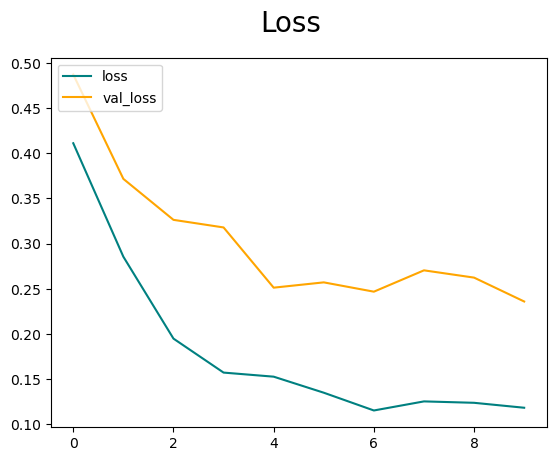

In [17]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

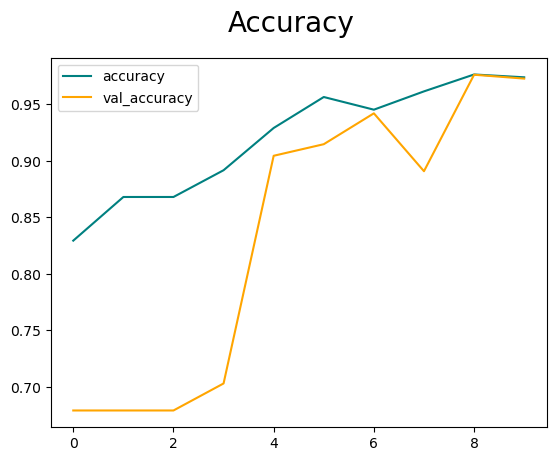

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate with test data

In [18]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [22]:
final_predictions = model.predict(testing_generator)

2/2 [==============================] - 1s 480ms/step


In [23]:
true_labels = np.squeeze(testing_generator.classes)

In [24]:
binary_preds = np.argmax(final_predictions, axis=1)

In [25]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=117.0>

In [26]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.125, Recall: 0.125, Accuracy: 0.7606837749481201


Здесь нормальная accuracy но плохие precision и recall потому что наш датасет для тестирование не равномерный: 101 для класса 0 и 16 для класса 1

In [27]:
# Function to load and preprocess an image for prediction
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 
    return img_array

In [28]:
# Path to the image you want to predict
image_path0 = 'sources/Pepper__bell___Bacterial_spot/3b9a94fb-856a-4576-94e3-6c16bf01118f___JR_B.Spot 8956.JPG'
image_path1 = 'sources/Potato___healthy/1ae826e2-5148-47bd-a44c-711ec9cc9c75___RS_HL 1954.JPG'

1/1 [==============================] - 0s 21ms/step


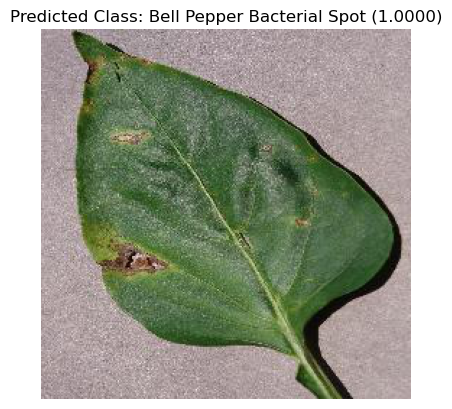

In [31]:
loaded_image = image_path0

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

1/1 [==============================] - 0s 27ms/step


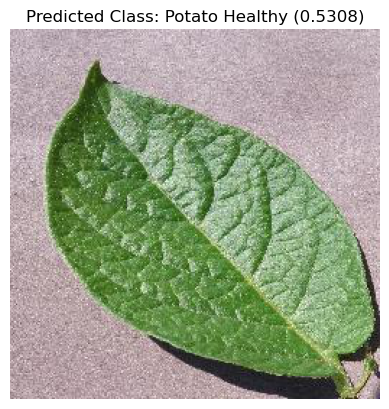

In [30]:
loaded_image = image_path1

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

# Многоклассовый классификатор

## Model A (Without pre-trained model)

### Создадим папку

In [11]:
root_binary = 'multi_class'

os.makedirs(os.path.join(root_binary, 'train'))
os.makedirs(os.path.join(root_binary, 'validation'))
os.makedirs(os.path.join(root_binary, 'testing'))

os.makedirs(os.path.join(root_binary, 'train/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'train/potato_healthy'))
os.makedirs(os.path.join(root_binary, 'train/bell_pepper_healthy'))

os.makedirs(os.path.join(root_binary, 'validation/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'validation/potato_healthy'))
os.makedirs(os.path.join(root_binary, 'validation/bell_pepper_healthy'))

os.makedirs(os.path.join(root_binary, 'testing/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'testing/potato_healthy'))
os.makedirs(os.path.join(root_binary, 'testing/bell_pepper_healthy'))

### Разделим данных на данные для обучения, валидации, и тестирования

In [12]:
BELL_PEPPER_BAC_DIR = "sources/" + data_dirs[0]
POTATO_HEALTHY_DIR = "sources/" + data_dirs[1]
BELL_PEPPER_HEALTHY_DIR = "sources/" + data_dirs[2]

TRAINING_DIR = "multi_class/train/"
VAL_DIR = "multi_class/validation/"
TEST_DIR = "multi_class/testing/"

TRAINING_BELL_PEPPER_BAC_DIR = os.path.join(TRAINING_DIR, "bell_pepper_bac/")
VAL_BELL_PEPPER_BAC_DIR = os.path.join(VAL_DIR, "bell_pepper_bac/")
TEST_BELL_PEPPER_BAC_DIR = os.path.join(TEST_DIR, "bell_pepper_bac/")

TRAINING_POTATO_HEALTHY_DIR = os.path.join(TRAINING_DIR, "potato_healthy/")
VAL_POTATO_HEALTHY_DIR = os.path.join(VAL_DIR, "potato_healthy/")
TEST_POTATO_HEALTHY_DIR = os.path.join(TEST_DIR, "potato_healthy/")

TRAINING_BELL_PEPPER_HEALTHY_DIR = os.path.join(TRAINING_DIR, "bell_pepper_healthy/")
VAL_BELL_PEPPER_HEALTHY_DIR = os.path.join(VAL_DIR, "bell_pepper_healthy/")
TEST_BELL_PEPPER_HEALTHY_DIR = os.path.join(TEST_DIR, "bell_pepper_healthy/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TRAINING_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_BELL_PEPPER_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_BELL_PEPPER_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(VAL_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(VAL_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)        
if len(os.listdir(VAL_BELL_PEPPER_HEALTHY_DIR)) > 0:
    for file in os.scandir(VAL_BELL_PEPPER_HEALTHY_DIR):
        os.remove(file.path)
  
if len(os.listdir(TEST_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TEST_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_POTATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_BELL_PEPPER_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_BELL_PEPPER_HEALTHY_DIR):
        os.remove(file.path)
        

        
# Define proportion of images used for training
split_train_size = .75
split_val_size = .2
split_test_size = .05

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(BELL_PEPPER_BAC_DIR, TRAINING_BELL_PEPPER_BAC_DIR, VAL_BELL_PEPPER_BAC_DIR, TEST_BELL_PEPPER_BAC_DIR, 
           split_train_size, split_val_size, split_test_size)
split_data(POTATO_HEALTHY_DIR, TRAINING_POTATO_HEALTHY_DIR, VAL_POTATO_HEALTHY_DIR, TEST_POTATO_HEALTHY_DIR, 
           split_train_size, split_val_size, split_test_size)
split_data(BELL_PEPPER_HEALTHY_DIR, TRAINING_BELL_PEPPER_HEALTHY_DIR, VAL_BELL_PEPPER_HEALTHY_DIR, TEST_BELL_PEPPER_HEALTHY_DIR, 
           split_train_size, split_val_size, split_test_size)


# Check that the number of images matches the expected output
print(f"There are {len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for training")
print(f"There are {len(os.listdir(TRAINING_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for training")
print(f"There are {len(os.listdir(TRAINING_BELL_PEPPER_HEALTHY_DIR))} images of {DATA_CLASSES[2]} for training")

print(f"\nThere are {len(os.listdir(VAL_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for validation")
print(f"There are {len(os.listdir(VAL_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for validation")
print(f"There are {len(os.listdir(VAL_BELL_PEPPER_HEALTHY_DIR))} images of {DATA_CLASSES[2]} for validation")

print(f"\nThere are {len(os.listdir(TEST_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for testing")
print(f"There are {len(os.listdir(TEST_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for testing")
print(f"There are {len(os.listdir(TEST_BELL_PEPPER_HEALTHY_DIR))} images of {DATA_CLASSES[2]} for testing")

There are 747 images of Bell Pepper Bacterial Spot for training
There are 114 images of Potato Healthy for training
There are 1108 images of Bell Pepper Healthy for training

There are 199 images of Bell Pepper Bacterial Spot for validation
There are 30 images of Potato Healthy for validation
There are 295 images of Bell Pepper Healthy for validation

There are 51 images of Bell Pepper Bacterial Spot for testing
There are 8 images of Potato Healthy for testing
There are 75 images of Bell Pepper Healthy for testing


### Генерирование этих данных

In [13]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)

Found 1969 images belonging to 3 classes.
Found 583 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


### Построить модель

In [57]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)      

In [59]:
# Compile the model
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Тренировки модели

In [60]:
# Train the model
history = model.fit(
    train_generator,
    epochs=15,  
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/15
31/31 [==============================] - 70s 2s/step - loss: 0.8235 - accuracy: 0.6338 - val_loss: 0.7810 - val_accuracy: 0.7290
Epoch 2/15
31/31 [==============================] - 75s 2s/step - loss: 0.5459 - accuracy: 0.8451 - val_loss: 0.6849 - val_accuracy: 0.7719
Epoch 3/15
31/31 [==============================] - 77s 2s/step - loss: 0.4869 - accuracy: 0.8558 - val_loss: 0.7447 - val_accuracy: 0.7564
Epoch 4/15
31/31 [==============================] - 89s 3s/step - loss: 0.4578 - accuracy: 0.8766 - val_loss: 0.5391 - val_accuracy: 0.7959
Epoch 5/15
31/31 [==============================] - 90s 3s/step - loss: 0.3905 - accuracy: 0.8873 - val_loss: 0.6173 - val_accuracy: 0.7393
Epoch 6/15
31/31 [==============================] - 86s 3s/step - loss: 0.3322 - accuracy: 0.8999 - val_loss: 0.4389 - val_accuracy: 0.8319
Epoch 7/15
31/31 [==============================] - 110s 4s/step - loss: 0.2949 - accuracy: 0.9142 - val_loss: 0.4357 - val_accuracy: 0.8353
Epoch 8/15
31/31 [=

### Plot performance

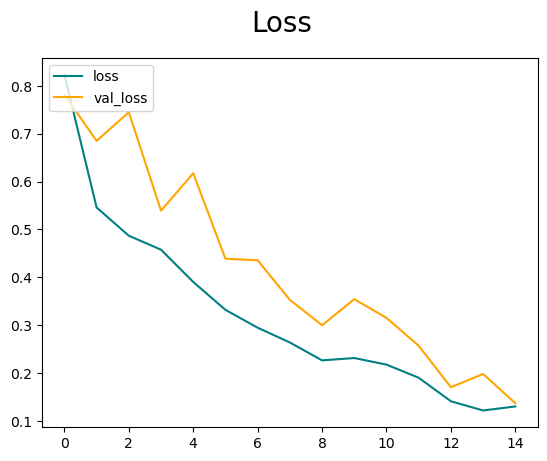

In [61]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

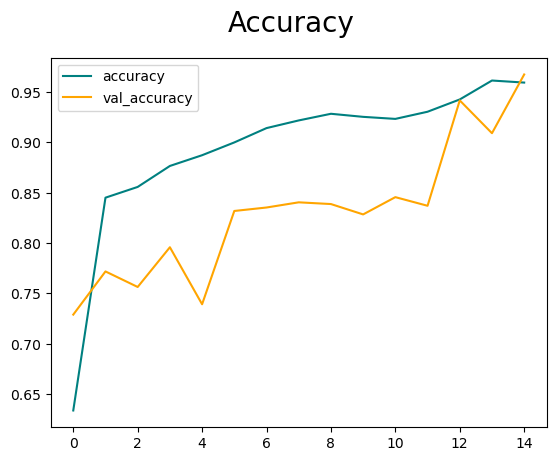

In [62]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate with test data

In [63]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [64]:
final_predictions = model.predict(testing_generator)

3/3 [==============================] - 7s 2s/step


In [65]:
true_labels = np.squeeze(testing_generator.classes)

In [66]:
binary_preds = np.argmax(final_predictions, axis=1)

In [67]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=134.0>

In [68]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.6144578456878662, Recall: 0.6144578456878662, Accuracy: 0.49253731966018677


### Evaluate with some data

In [73]:
# Path to the image you want to predict
image_path0 = 'sources/Pepper__bell___Bacterial_spot/3b9a94fb-856a-4576-94e3-6c16bf01118f___JR_B.Spot 8956.JPG'
image_path1 = 'sources/Potato___healthy/c6abf1da-b06f-4cd2-8af6-d68be5eff6f9___RS_HL 1766.JPG'
image_path2 = 'sources/Pepper__bell___healthy/fef57c46-de88-400b-81d1-6e2a7e990ee0___JR_HL 8670.JPG'

1/1 [==============================] - 0s 47ms/step


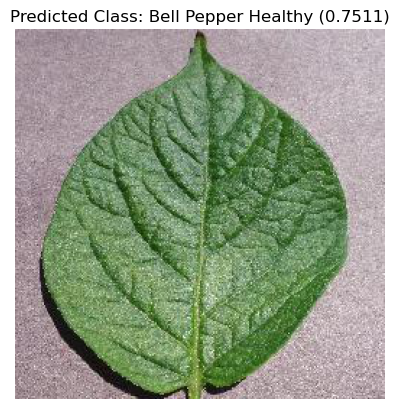

In [74]:
loaded_image = image_path2

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

## Модель B (with pre-trained model)

In [75]:
from tensorflow.keras.applications import ResNet50

In [82]:
# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

In [83]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)

Found 1969 images belonging to 3 classes.
Found 584 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [84]:
# Make the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [85]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               67109376  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 90698627 (345.99 MB)
Trainable params: 67110915 (256.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [86]:
# Compile the model
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [87]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
31/31 [==============================] - 128s 4s/step - loss: 12.2968 - accuracy: 0.4972 - val_loss: 1.2882 - val_accuracy: 0.5051
Epoch 2/10
31/31 [==============================] - 136s 4s/step - loss: 0.9288 - accuracy: 0.5576 - val_loss: 0.9056 - val_accuracy: 0.5873
Epoch 3/10
31/31 [==============================] - 147s 5s/step - loss: 0.9272 - accuracy: 0.5561 - val_loss: 0.9606 - val_accuracy: 0.5702
Epoch 4/10
31/31 [==============================] - 147s 5s/step - loss: 0.9143 - accuracy: 0.5444 - val_loss: 0.9625 - val_accuracy: 0.5223
Epoch 5/10
31/31 [==============================] - 142s 5s/step - loss: 0.8981 - accuracy: 0.5424 - val_loss: 0.9708 - val_accuracy: 0.5668
Epoch 6/10
31/31 [==============================] - 151s 5s/step - loss: 0.9427 - accuracy: 0.5719 - val_loss: 0.9369 - val_accuracy: 0.5925
Epoch 7/10
31/31 [==============================] - 174s 6s/step - loss: 0.8846 - accuracy: 0.5526 - val_loss: 0.8973 - val_accuracy: 0.6284
Epoch 8/10
3

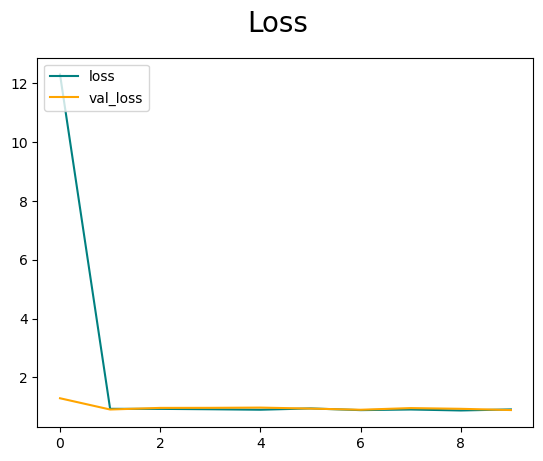

In [88]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

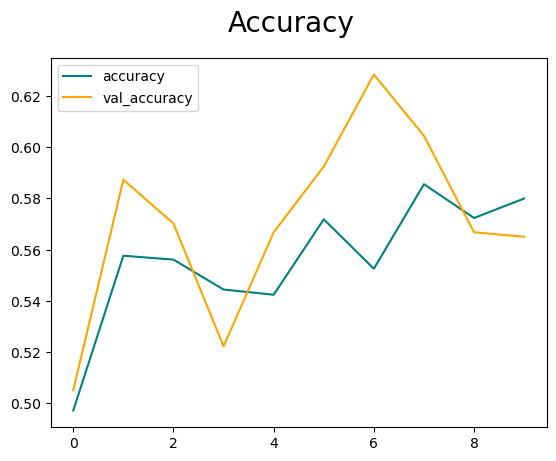

In [89]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [90]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [91]:
final_predictions = model.predict(testing_generator)

3/3 [==============================] - 7s 2s/step


In [92]:
true_labels = np.squeeze(testing_generator.classes)

In [93]:
binary_preds = np.argmax(final_predictions, axis=1)

In [94]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=134.0>

In [95]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.6229507923126221, Recall: 0.9156626462936401, Accuracy: 0.5522388219833374


In [96]:
# Path to the image you want to predict
image_path0 = 'sources/Pepper__bell___Bacterial_spot/3b9a94fb-856a-4576-94e3-6c16bf01118f___JR_B.Spot 8956.JPG'
image_path1 = 'sources/Potato___healthy/c6abf1da-b06f-4cd2-8af6-d68be5eff6f9___RS_HL 1766.JPG'
image_path2 = 'sources/Pepper__bell___healthy/fef57c46-de88-400b-81d1-6e2a7e990ee0___JR_HL 8670.JPG'

1/1 [==============================] - 0s 151ms/step


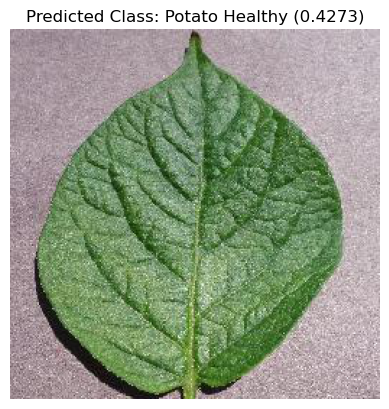

In [102]:
loaded_image = image_path1

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()